x_train shape: (7328, 100, 100, 3)
y_train shape: (7328, 15)
x_test shape: (1841, 100, 100, 3)
y_test shape: (1841, 15)
Epoch 1/2
229/229 ━━━━━━━━━━━━━━━━━━━━ 237s 1s/step - accuracy: 0.2494 - loss: 2.5566 - val_accuracy: 0.4720 - val_loss: 1.8133 - learning_rate: 0.0010
Epoch 2/2
229/229 ━━━━━━━━━━━━━━━━━━━━ 309s 1s/step - accuracy: 0.4511 - loss: 1.7745 - val_accuracy: 0.5253 - val_loss: 1.5323 - learning_rate: 0.0010
58/58 ━━━━━━━━━━━━━━━━━━━━ 54s 924ms/step - accuracy: 0.5447 - loss: 1.4776


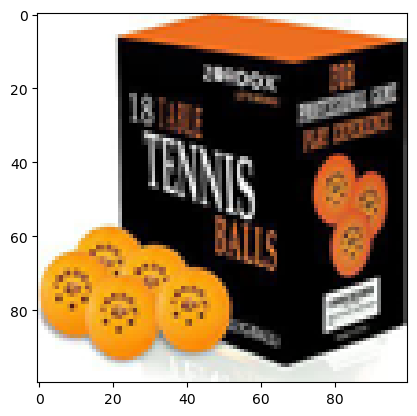

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
Predicted Class: 12, Actual Class: 12


In [5]:
import os
import numpy as np
from PIL import Image, UnidentifiedImageError
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16

# Function to load images from a directory and label them
def load_images_from_folder(folder):
    images = []
    labels = []
    class_names = sorted([d for d in os.listdir(folder) if os.path.isdir(os.path.join(folder, d))])  # Filter to only directories
    for label, class_name in enumerate(class_names):
        class_folder = os.path.join(folder, class_name)
        for filename in os.listdir(class_folder):
            img_path = os.path.join(class_folder, filename)
            try:
                # Open the image file and convert to RGB
                with Image.open(img_path) as img:
                    img = img.convert('RGB')  # Ensure all images are RGB
                    img = img.resize((100, 100))
                    img_array = np.array(img)
                    images.append(img_array)
                    labels.append(label)
            except (IOError, UnidentifiedImageError) as e:
                # Skip files that can't be identified as images
                print(f"Skipping file {img_path}: {e}")
    return np.array(images), np.array(labels)

# Load training and testing data
train_folder = 'multiclass CNN/train'
test_folder = 'multiclass CNN/test'

x_train, y_train = load_images_from_folder(train_folder)
x_test, y_test = load_images_from_folder(test_folder)

# Normalize the data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Convert labels to categorical (one-hot encoding)
num_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Print the shapes of the datasets
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Use a pre-trained model (VGG16)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
base_model.trainable = False  # Freeze the base model

# Build the model for multiclass classification
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # Updated for multiclass
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Train the model
model.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=2, validation_data=(x_test, y_test), callbacks=[early_stopping, lr_scheduler])

# Evaluate the model
model.evaluate(x_test, y_test)




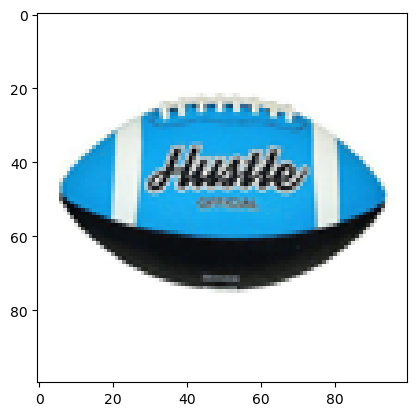

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Predicted Class: basketball, Actual Class: american_football


In [13]:
# Display a random image and its prediction
idx2 = random.randint(0, len(x_test) - 1)
plt.imshow(x_test[idx2])
plt.show()

# Predict the class of the image
y_pred = model.predict(x_test[idx2, :].reshape(1, 100, 100, 3))
predicted_class_idx = np.argmax(y_pred)

# Get the class names from the folder structure
class_names = sorted([d for d in os.listdir(train_folder) if os.path.isdir(os.path.join(train_folder, d))])

# Map the predicted class index and actual class index to their respective class names
predicted_class_name = class_names[predicted_class_idx]
actual_class_name = class_names[np.argmax(y_test[idx2])]

print(f"Predicted Class: {predicted_class_name}, Actual Class: {actual_class_name}")
